# Fremont Bridge Cyclists Crossings
by Michael Kearns

# Business Understanding
Seattle is home to many cyclists who ride for both recreational or commuting purposes. Seattle has already developed extensive infrastructure for their residents that include designated walking/cycling paths and protected bike lines. Unique to Seattle geography is that North Seattle and Downtown are split by bodies of water that connect the Puget Sound to Lake Washington. This requires riders who travel from North Seattle to Downtown to cross a bridge that motor vehicles also use. I would like to build a model that can predict the number of cyclists that cross a bridge dependent on the daily weather. This project will specifically look at the Fremont Bridge, which has direct access to the South Lake Union and Downtown areas that host many major companies and business districts. The goal is this model could be used by the Seattle Department of Transportation to help improve or provide safer travel for cyclists across this bridge.

# Data Understanding
Data for this project will be collected from multiple sources. First, the city of Seattle tracks the number of cyclists that cross the Fremont bridge in both the northbound and southbound directions. Second, historical weather data from the National Center for Environmental Information (NCEI) is collected that includes daily temperature, precipitation levels, and snow levels. The data will range between 2013-2024. 
## Data Preparation
A key difference between the two datasets is the cyclist dataset has hourly recordings and the weather data is daily. Therefore, the cycling dataset will need to be converted to report daily numbers. All data considered will be numerical, and will have to be cleaned for possible cases of missing data or incorrectly recorded values.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


#import csv file
bike = pd.read_csv('data/Fremont_Bridge_Bicycle_Counter_20250217.csv')

#check dataframe info
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107352 entries, 0 to 107351
Data columns (total 4 columns):
 #   Column                                                              Non-Null Count   Dtype  
---  ------                                                              --------------   -----  
 0   Date                                                                107352 non-null  object 
 1   Fremont Bridge Sidewalks, south of N 34th St Total                  107324 non-null  float64
 2   Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk  107324 non-null  float64
 3   Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk  107324 non-null  float64
dtypes: float64(3), object(1)
memory usage: 3.3+ MB


In [2]:
#Rename column names for simplicity
bike.columns = ['Date-Hr','Total','WestSidewalk','EastSidewalk']

In [3]:
bike['Date'] = bike['Date-Hr'].str[:10]
bike['Hr'] = bike['Date-Hr'].str[11:]

In [4]:
#Convert Date to datetime format
bike['Date'] = pd.to_datetime(bike['Date'])

In [5]:
#Create new dataframe that sums daily crossing between 2013 and 2024
bike_filtered = bike[bike['Date']>'2012-12-31']
bike_daily = bike.groupby(bike_filtered['Date'])[['Total','WestSidewalk','EastSidewalk']].sum()

In [6]:
bike_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4383 entries, 2013-01-01 to 2024-12-31
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Total         4383 non-null   float64
 1   WestSidewalk  4383 non-null   float64
 2   EastSidewalk  4383 non-null   float64
dtypes: float64(3)
memory usage: 137.0 KB


In [7]:
#import weather data
weather = pd.read_csv('data/sea-tac_weather_2024.csv',header=1)

In [8]:
#Filter weather data to match timeframe of bike data
weather_filtered = weather[(weather['Date']>'2012-12-31')&(weather['Date']<'2025-01-01')]

In [9]:
#simplify column names
weather_filtered.columns = ['Date','TAVG','TMAX','TMIN','PRCP','SNOW','SNWD']

In [10]:
#drop rows with missing data
weather_filtered_clean = weather_filtered.dropna(axis = 0)
#reset weather dataframe
weather_filtered_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4286 entries, 23832 to 28124
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4286 non-null   object 
 1   TAVG    4286 non-null   float64
 2   TMAX    4286 non-null   float64
 3   TMIN    4286 non-null   float64
 4   PRCP    4286 non-null   float64
 5   SNOW    4286 non-null   float64
 6   SNWD    4286 non-null   float64
dtypes: float64(6), object(1)
memory usage: 267.9+ KB


In [11]:
weather_df = weather_filtered_clean[['TAVG','TMAX','TMIN','PRCP','SNOW','SNWD']]
weather_df['Date'] = pd.to_datetime(weather_filtered_clean['Date'])
weather_df.set_index('Date', inplace=True)

# Exploratory Data Analysis

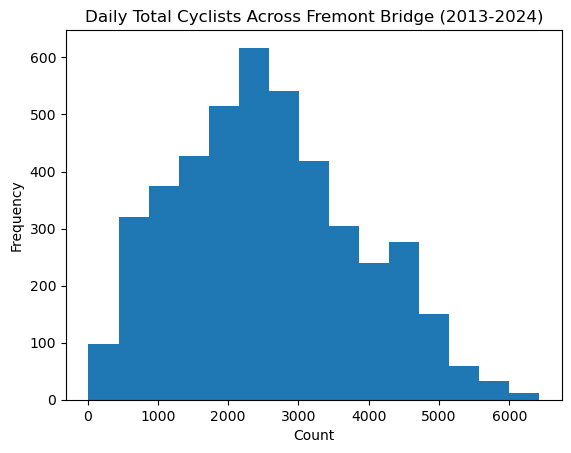

In [12]:
plt.hist(bike_daily['Total'],bins = 15)
plt.title('Daily Total Cyclists Across Fremont Bridge (2013-2024)')
plt.xlabel('Count')
plt.ylabel('Frequency');

In [13]:
bike_daily.describe()

,Total,WestSidewalk,EastSidewalk
count,4383.000000,4383.000000,4383.000000
mean,2561.243669,1093.742642,1467.501027
std,1274.176415,552.827540,767.395099
min,11.000000,9.000000,2.000000
25%,1589.000000,669.500000,889.500000
50%,2457.000000,1064.000000,1388.000000
75%,3403.000000,1424.000000,1986.500000
max,6428.000000,3008.000000,4050.000000


In [14]:
def daily_avg_plot(df,y,title,ylabel):
    data = df
    data['day_of_year'] = data.index.dayofyear
    daily_avg = data.groupby('day_of_year')[y].mean()
    
    
    date_labels = ['Jan 01', 'Feb 01', 'Mar 01', 'Apr 01', 'May 01', 'Jun 01', 'Jul 01', 'Aug 01', 'Sept 01', 'Oct 01', 'Nov 01', 'Dec 01']
    ticks = [1,32,61,92,122,153,183,214,245,275,306,336]

    plt.figure(figsize=(10, 6))

    plt.plot(daily_avg.index, daily_avg.values, marker='o', markersize = 3, linestyle='-')

    plt.xlabel('Date')
    plt.xticks(ticks = ticks, labels=date_labels, rotation=45)

    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()



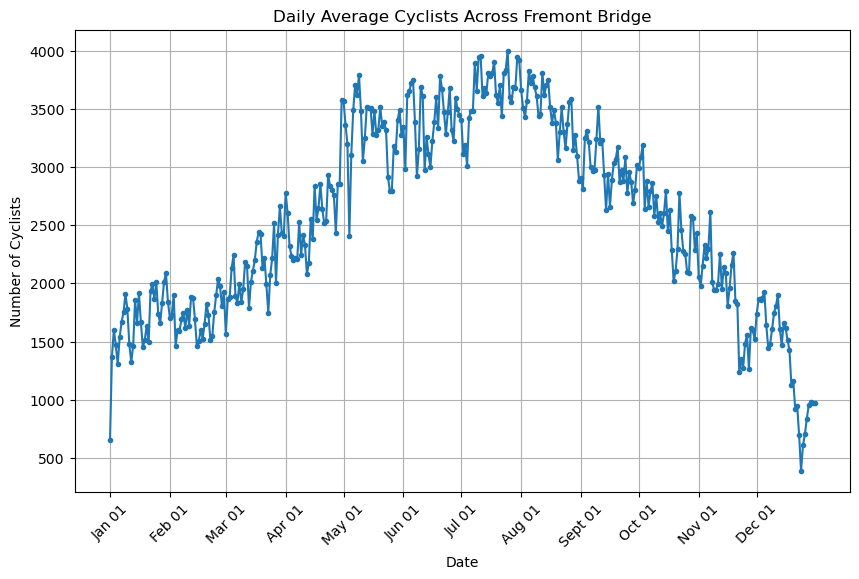

In [15]:
title = 'Daily Average Cyclists Across Fremont Bridge'
ylabel = 'Number of Cyclists'
daily_avg_plot(bike_daily,'Total',title,ylabel)

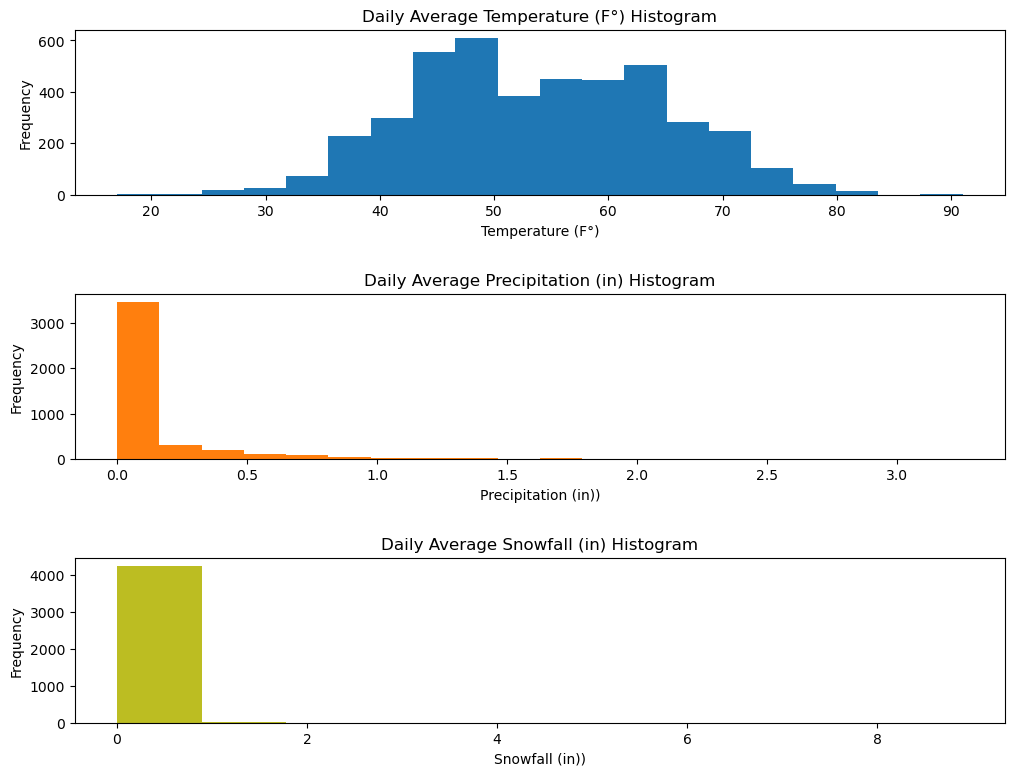

In [16]:
fig, axs = plt.subplots(3,1, figsize = (12,9))

plt.subplots_adjust(wspace=0.4, hspace=0.6)

axs[0].hist(weather_filtered_clean['TAVG'],bins = 20 , color = 'tab:blue')
axs[0].set_title('Daily Average Temperature (F°) Histogram')
axs[0].set_xlabel('Temperature (F°)')
axs[0].set_ylabel('Frequency')

axs[1].hist(weather_filtered_clean['PRCP'],bins = 20 , color = 'tab:orange')
axs[1].set_title('Daily Average Precipitation (in) Histogram')
axs[1].set_xlabel('Precipitation (in))')
axs[1].set_ylabel('Frequency')

axs[2].hist(weather_filtered_clean['SNOW'],bins = 10 , color = 'tab:olive')
axs[2].set_title('Daily Average Snowfall (in) Histogram')
axs[2].set_xlabel('Snowfall (in))')
axs[2].set_ylabel('Frequency');


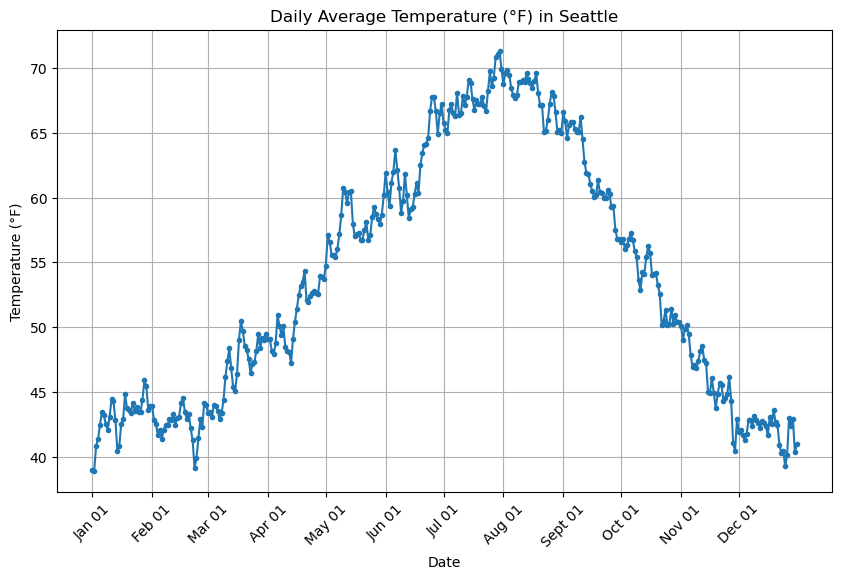

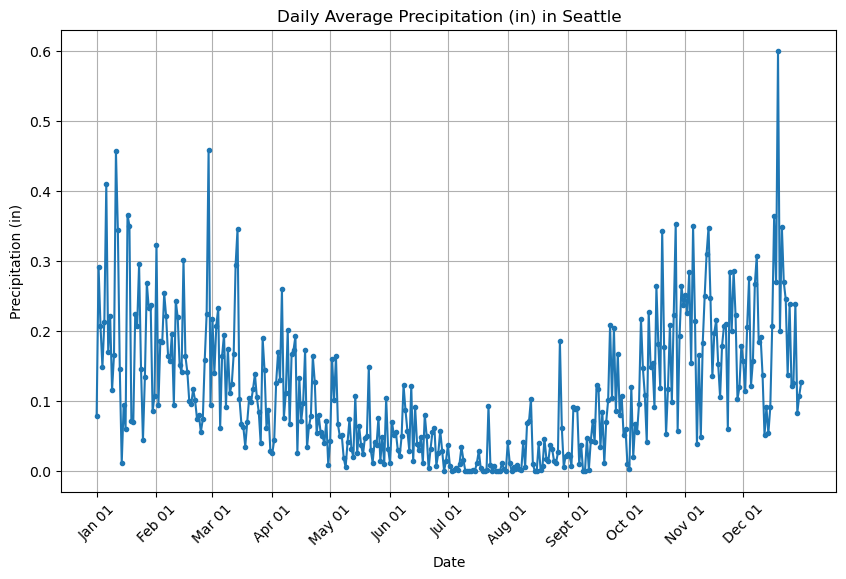

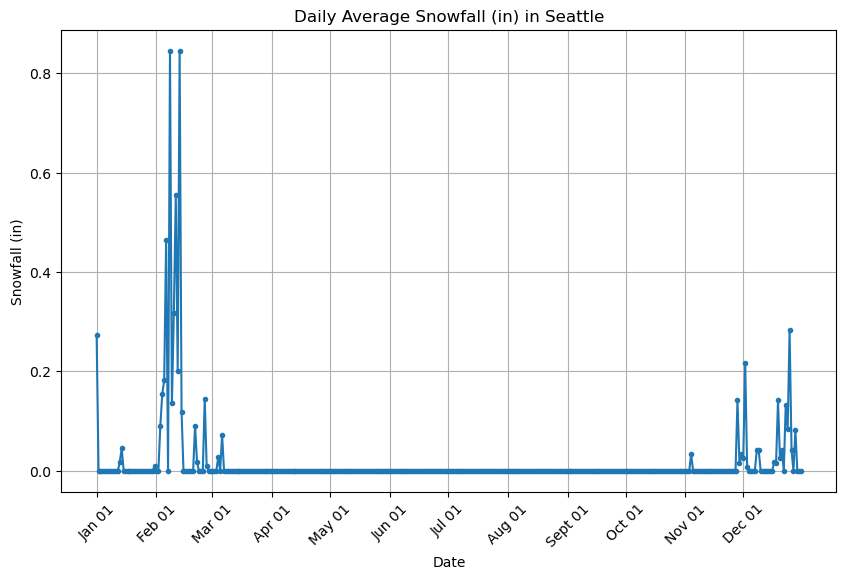

In [17]:
title = ['Daily Average Temperature (°F) in Seattle', 
         'Daily Average Precipitation (in) in Seattle', 
         'Daily Average Snowfall (in) in Seattle',]
ylabel = ['Temperature (°F)',
          'Precipitation (in)',
          'Snowfall (in)']
y = ['TAVG','PRCP','SNOW']

for i in range(0,3):
    daily_avg_plot(weather_df,y[i],title[i],ylabel[i])

In [18]:
#Combine bike and weather data together into full datset

full_df = bike_daily.join(weather_df, how = 'inner',lsuffix='_bike', rsuffix='_weather')

In [19]:
full_df.head()

,Total,WestSidewalk,EastSidewalk,day_of_year_bike,TAVG,TMAX,TMIN,PRCP,SNOW,SNWD,day_of_year_weather
Date,,,,,,,,,,,
2013-04-01,3248.0,1594.0,1654.0,91,55.0,63.0,47.0,0.00,0.0,0.0,91
2013-04-02,3287.0,1602.0,1685.0,92,53.0,57.0,48.0,0.00,0.0,0.0,92
2013-04-03,3486.0,1747.0,1739.0,93,53.0,62.0,46.0,0.00,0.0,0.0,93
2013-04-04,2007.0,991.0,1016.0,94,54.0,58.0,50.0,0.33,0.0,0.0,94
2013-04-05,1842.0,928.0,914.0,95,54.0,57.0,50.0,0.73,0.0,0.0,95


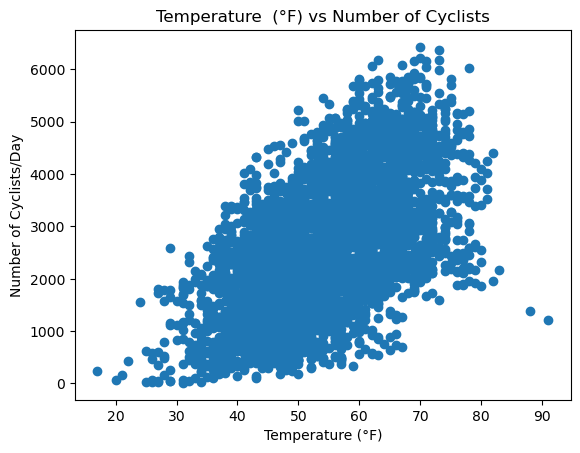

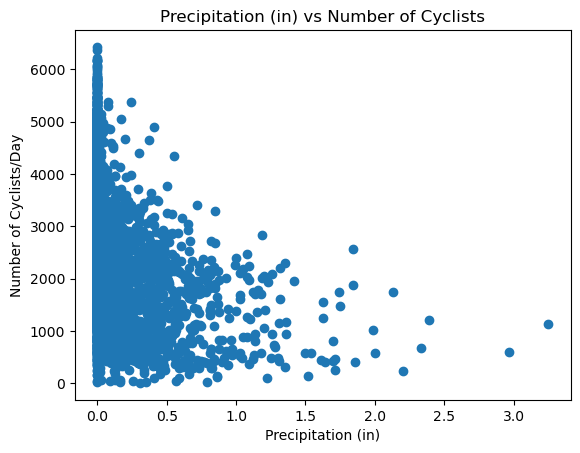

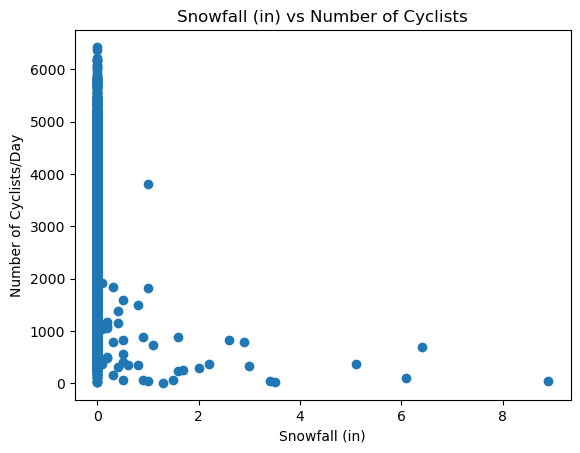

In [20]:
title = ['Temperature  (°F) vs Number of Cyclists', 
         'Precipitation (in) vs Number of Cyclists', 
         'Snowfall (in) vs Number of Cyclists',]
xlabel = ['Temperature (°F)',
          'Precipitation (in)',
          'Snowfall (in)']
x = ['TAVG','PRCP','SNOW']

for i in range(0,3):
    plt.scatter(full_df[x[i]],full_df['Total'])
    plt.title(title[i])
    plt.xlabel(xlabel[i])
    plt.ylabel('Number of Cyclists/Day')
    plt.show();



In [21]:
x = ['TAVG','PRCP','SNOW']
filtered_df = full_df


# IQR Calculation
Q1 = filtered_df['TAVG'].quantile(0.25)
Q3 = filtered_df['TAVG'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
filtered_df = filtered_df[(filtered_df['TAVG'] >= lower_bound) & (filtered_df['TAVG'] <= upper_bound)]
filtered_df = filtered_df[(filtered_df['PRCP'] < 2) & (filtered_df['SNOW'] < 2)]

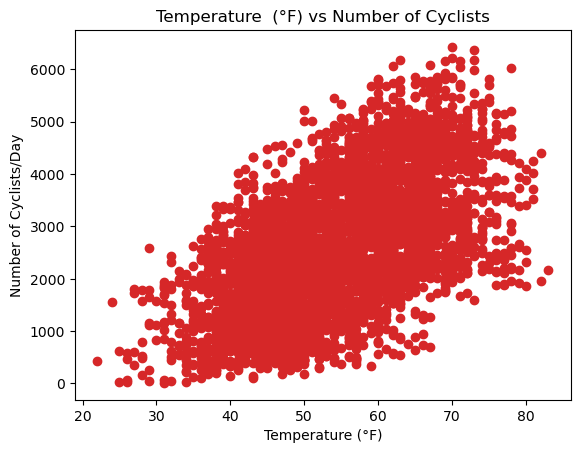

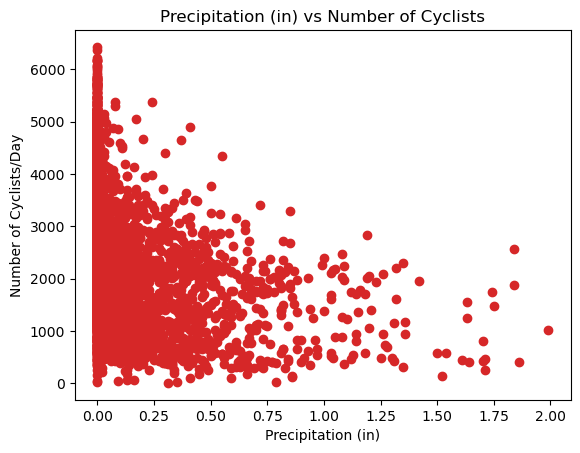

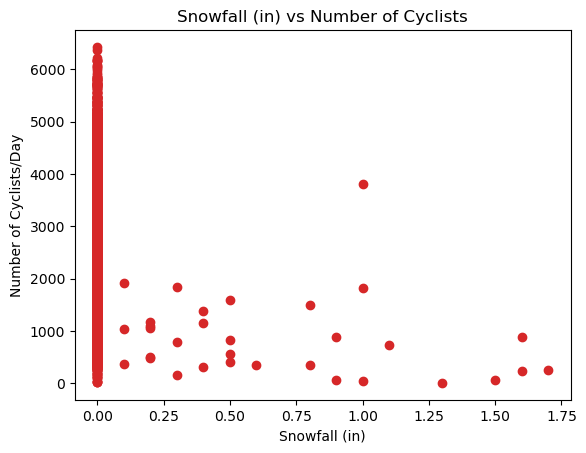

In [22]:
for i in range(0,3):
    plt.scatter(filtered_df[x[i]],filtered_df['Total'], color='tab:red')
    plt.title(title[i])
    plt.xlabel(xlabel[i])
    plt.ylabel('Number of Cyclists/Day')
    plt.show();

In [23]:
#mark if the the day is a weekend
filtered_df['is_weekend'] = filtered_df.index.weekday >= 5
filtered_df['is_weekend'] = filtered_df['is_weekend'].astype(int)

# Modeling

## Baseline Model

Should remove outliers.

In [31]:
model_columns = ['TAVG','PRCP','SNOW','is_weekend'] #not using date, date is use as index to organize data

X = filtered_df[model_columns]
y = filtered_df['Total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.2, random_state = 42)

In [32]:
#bool_features = ['is_weekend']
#continuous_features = ['TAVG','PRCP','SNOW']

#scaler = StandardScaler()

#X_train_scaled = scaler.fit_transform(X_train[continuous_features])
#X_test_scaled = scaler.transform(X_test[continuous_features])

In [33]:
baseline = LinearRegression()
baseline.fit(X_train, y_train)

LinearRegression()

In [34]:
print("Intercept:", baseline.intercept_)
print("Coefficients:", baseline.coef_)

Intercept: -380.59617296972965
Coefficients: [   64.67122884 -1409.59851364  -100.12769233 -1287.06361007]


In [35]:
y_train_pred = baseline.predict(X_train)
y_test_pred = baseline.predict(X_test)

r2_train = baseline.score(X_train, y_train)
r2_test = baseline.score(X_test, y_test)

print(f"R² on Training Data: {r2_train:.4f}")
print(f"R² on Test Data: {r2_test:.4f}")

# Alternatively, use r2_score from sklearn.metrics
print(f"R² (Test) using r2_score: {r2_score(y_test, y_test_pred):.4f}")

R² on Training Data: 0.6221
R² on Test Data: 0.6347
R² (Test) using r2_score: 0.6347


In [36]:
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print(f"RMSE on Training Data: {rmse_train:.2f}")
print(f"RMSE on Test Data: {rmse_test:.2f}")

RMSE on Training Data: 784.13
RMSE on Test Data: 758.18


# Final Model

# Conclusions

## Limitations

## Recommendations

## Next Steps